<a href="https://colab.research.google.com/github/Rms78/Act2/blob/main/Actividad_2_Redes_Neuronales_Convolucionales_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ACTIVIDAD 2: REDES NEURONALES CONVOLUCIONALES

---

En esta actividad, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


## Carga de los datos

In [2]:
%pip install opencv-python

In [3]:
import cv2
import os
import numpy as np
import keras
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
from tensorflow.keras import layers



In [4]:
# Primero, bajamos los datos de entrenamiento
keras.utils.get_file(fname="simpsons_train.tar.gz",
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets


# Hacemos lo mismo con los datos de test
keras.utils.get_file(fname="simpsons_test.tar.gz",
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

10658925/10658925 [==============================] - 3s 0us/step


In [5]:
# Descomprimimos el archivo en tmp para visualizar
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /tmp/simpsons

tar: /tmp/simpsons: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [6]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel',
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson',
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak',
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 60

In [7]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.

    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.

    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas

    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [8]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [9]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [10]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

bart_simpson


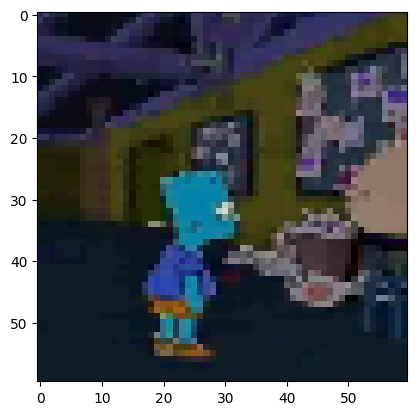

In [11]:
plt.imshow(X_t[2]) # recordad que siempre es preferible trabajar en blanco y negro

print(MAP_CHARACTERS[y_t[2]]) #imprimimos también la etiqueta


In [12]:
#normalización, tal y como pide la práctica
X = X / 255.0
X_t = X_t / 255.0

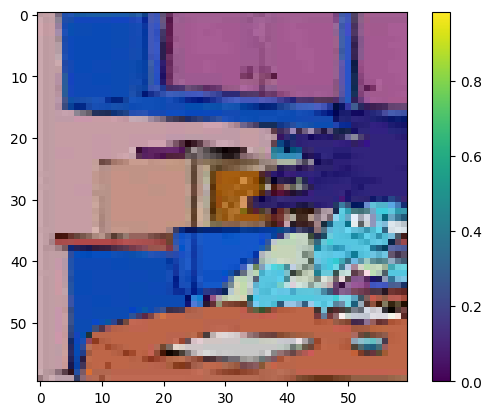

Etiqueta de la primera imagen:  17 -> sideshow_bob


In [13]:
X.shape

plt.figure()
plt.imshow(X[0])#muestra lo que hay en un registro concreto, en este caso el 0
plt.colorbar()
plt.grid(False)
plt.show()
print("Etiqueta de la primera imagen: ",y[0],"->",MAP_CHARACTERS[y[0]]) #comrpobamos que la etiqueta coincide con la imagen

[[[0.49411765 0.49411765 0.35294118]
  [0.49411765 0.49411765 0.35294118]
  [0.49411765 0.49411765 0.35294118]
  ...
  [0.6        0.52941176 0.45098039]
  [0.09019608 0.05490196 0.03529412]
  [0.58823529 0.59607843 0.42745098]]

 [[0.49411765 0.49411765 0.35294118]
  [0.49411765 0.49411765 0.35294118]
  [0.49411765 0.49411765 0.35294118]
  ...
  [0.58431373 0.54117647 0.45882353]
  [0.10980392 0.0627451  0.03921569]
  [0.56470588 0.55686275 0.4       ]]

 [[0.49411765 0.49411765 0.35294118]
  [0.49411765 0.49411765 0.35294118]
  [0.49411765 0.49411765 0.35294118]
  ...
  [0.58823529 0.55294118 0.44705882]
  [0.07843137 0.03921569 0.03529412]
  [0.59215686 0.54901961 0.38039216]]

 ...

 [[0.00784314 0.11372549 0.20784314]
  [0.01568627 0.11764706 0.21176471]
  [0.00392157 0.09411765 0.18823529]
  ...
  [0.01960784 0.12156863 0.21568627]
  [0.03137255 0.1372549  0.23137255]
  [0.01568627 0.1254902  0.21960784]]

 [[0.00784314 0.12941176 0.21960784]
  [0.01568627 0.1254902  0.21960784]


(890, 60, 60, 3)

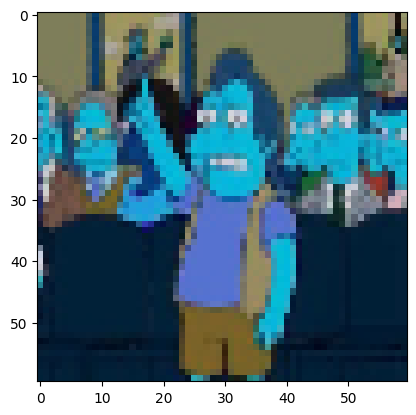

In [14]:
import numpy as np
np.set_printoptions(linewidth=200)
import matplotlib.pyplot as plt
plt.imshow(X_t[0], cmap="gray") # recordad que siempre es preferible trabajar en blanco y negro
#
print(X_t[0])
print(MAP_CHARACTERS[y_t[0]])#imprimimos también la etiqueta

X_t.shape


## Ejercicio

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de, al menos, **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos ni mucho menos, esto son ideas orientativas de aspectos que podéis explorar):

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   [ *algo más difícil* ] Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas:
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

**Arquitectura de la Red Neuronal Convolucional**
Para este problema, hemos diseñado varias arquitecturas de CNNs con diferentes profundidades y configuraciones. Finalmente, la arquitectura que ha mostrado los mejores resultados se describe a continuación.

In [15]:
#Definimos la arquitectura de la red convolucional
#lo cierto es que hay infinidad de opciones,
#yo he optado por esta que se parece bastante


def Mi_Red_Convolucional(input_shape, num_classes):
   # Utilizamos Sequential para apilar las capas de la red de manera lineal
    model = keras.Sequential([
        # Primera capa convolucional con 32 filtros de tamaño 3x3 y función de activación ReLU
        # La capa input_shape define la forma de los datos de entrada (tamaño de la imagen y canales de color, acordarse qeu trabajamos en RGB)
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),

        # Capa de MaxPooling para reducir las dimensiones de las características
        layers.MaxPooling2D((2, 2)),

        # Segunda capa convolucional con 64 filtros de tamaño 3x3 y función de activación ReLU
        layers.Conv2D(64, (3, 3), activation='relu'),

        # Otra capa de MaxPooling para seguir reduciendo las dimensiones
        layers.MaxPooling2D((2, 2)),

        # Tercera capa convolucional con 128 filtros de tamaño 3x3 y función de activación ReLU
        layers.Conv2D(128, (3, 3), activation='relu'),

        # Última capa de MaxPooling
        layers.MaxPooling2D((2, 2)),

        # Aplanamos las características para que puedan ser utilizadas por las capas densas (fully connected)
        layers.Flatten(),

        # Capa densa (fully connected) con 512 neuronas y función de activación ReLU
        layers.Dense(512, activation='relu'),

        # Capa Dropout para evitar el overfitting, desactivando el 50% de las neuronas de manera aleatoria
        # tal y como aprendimos en la práctica anterior, este valor es interesante y podemos testear con varias opciones
        layers.Dropout(0.5),

        # Capa de salida con 'num_classes' neuronas (tantas como clases en la clasificación) y función de activación softmax
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

######################################################
# Definimos hiperparámetros y compilamos el modelo
# 'input_shape' define el tamaño de las imágenes de entrada y los canales de color
input_shape = (IMG_SIZE, IMG_SIZE, 3)

# 'num_classes' es el número de clases para la clasificación (basado en el número de personajes)
num_classes = len(MAP_CHARACTERS)

# Instanciamos el modelo con la arquitectura defnida antes
model = Mi_Red_Convolucional(input_shape, num_classes)

# compilamos eligiendo el optimizador (adam en nuestro caso), la función de pérdida y la métrica elegida
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenamos el modelo con los datos de entrada 'X' y las etiquetas 'y'
# Definimos 20 épocas, un 20% de los datos para validación y un tamaño de lote de 64
history = model.fit(X, y, epochs=20, validation_split=0.2, batch_size=64)



Epoch 1/20
238/238 [==============================] - 12s 22ms/step - loss: 2.1044 - accuracy: 0.3504 - val_loss: 1.5438 - val_accuracy: 0.5315
Epoch 2/20
238/238 [==============================] - 5s 20ms/step - loss: 1.2824 - accuracy: 0.6151 - val_loss: 1.0075 - val_accuracy: 0.6976
Epoch 3/20
238/238 [==============================] - 3s 12ms/step - loss: 0.9012 - accuracy: 0.7226 - val_loss: 0.7854 - val_accuracy: 0.7681
Epoch 4/20
238/238 [==============================] - 2s 10ms/step - loss: 0.6570 - accuracy: 0.8013 - val_loss: 0.6657 - val_accuracy: 0.8013
Epoch 5/20
238/238 [==============================] - 2s 10ms/step - loss: 0.4937 - accuracy: 0.8493 - val_loss: 0.6465 - val_accuracy: 0.8118
Epoch 6/20
238/238 [==============================] - 2s 10ms/step - loss: 0.3747 - accuracy: 0.8821 - val_loss: 0.6016 - val_accuracy: 0.8242
Epoch 7/20
238/238 [==============================] - 3s 13ms/step - loss: 0.2724 - accuracy: 0.9113 - val_loss: 0.6019 - val_accuracy: 0.841

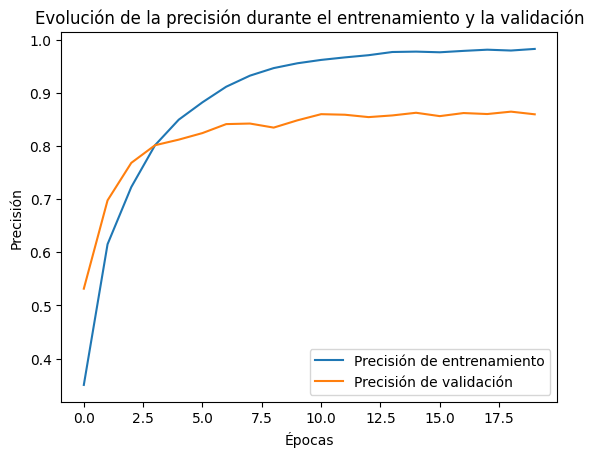

In [17]:
######################################################
# Graficamos la evolución de las precisiones durante el entrenamiento y la validación
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Evolución de la precisión durante el entrenamiento y la validación')
plt.legend()
plt.show()

**Evaluación del Modelo**
Hemos evaluado el modelo en el conjunto de test y obtenido métricas de precisión y recall por clase.

28/28 - 0s - loss: 0.1548 - accuracy: 0.9719 - 415ms/epoch - 15ms/step
Precisión en el conjunto de test: 0.9719
28/28 [==============================] - 0s 2ms/step
                          precision    recall  f1-score   support

  abraham_grampa_simpson       1.00      0.92      0.96        48
  apu_nahasapeemapetilon       0.92      0.98      0.95        50
            bart_simpson       0.91      1.00      0.95        50
charles_montgomery_burns       0.96      0.92      0.94        48
            chief_wiggum       1.00      1.00      1.00        50
          comic_book_guy       1.00      1.00      1.00        49
          edna_krabappel       0.94      0.98      0.96        50
           homer_simpson       0.89      0.96      0.92        50
           kent_brockman       0.98      0.94      0.96        50
        krusty_the_clown       1.00      1.00      1.00        50
            lisa_simpson       1.00      0.90      0.95        50
           marge_simpson       1.00      1

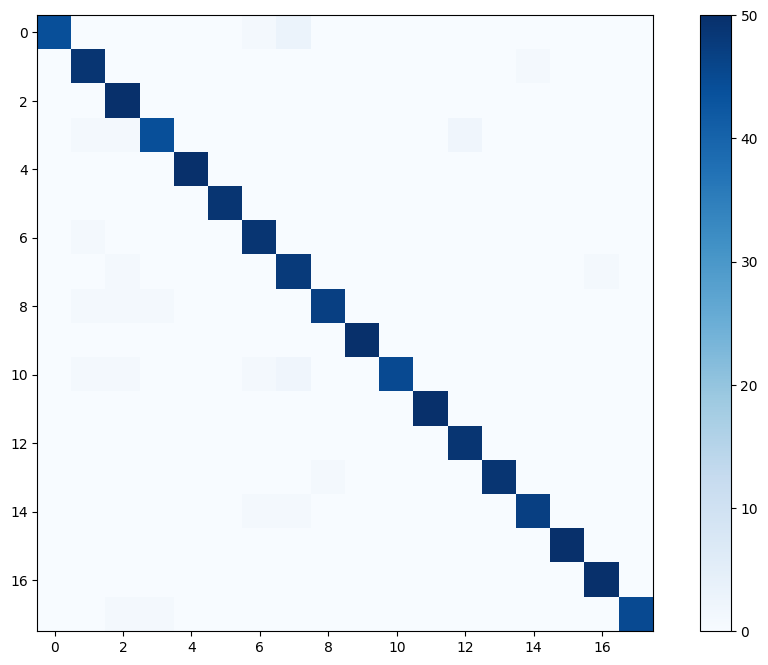

In [16]:
# Evaluación en el dataset de test
# En este bloque, evaluamos el modelo en el conjunto de datos de prueba
# para obtener la pérdida y la precisión.
test_loss, test_acc = model.evaluate(X_t, y_t, verbose=2)
print(f"Precisión en el conjunto de test: {test_acc:.4f}")

# Importamos las funciones para el reporte de clasificación y la matriz de confusión
from sklearn.metrics import classification_report, confusion_matrix

# Realizamos predicciones en el conjunto de datos de prueba
y_pred = model.predict(X_t)
# Convertimos las predicciones en clases (tomando el índice con mayor probabilidad)
y_pred_classes = np.argmax(y_pred, axis=1)

# Imprimimos el informe de clasificación, que muestra métricas como la precisión,
# la recuperación y el F1-score para cada clase.
print(classification_report(y_t, y_pred_classes, target_names=MAP_CHARACTERS.values()))

# Calculamos la matriz de confusión para ver el rendimiento del modelo
# en términos de verdaderos positivos, falsos positivos, verdaderos negativos y falsos negativos.
conf_matrix = confusion_matrix(y_t, y_pred_classes)

# la graficamos:
plt.figure(figsize=(12, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
plt.colorbar()
plt.show()

# El modelo muestra una precisión elevadísima en el conjunto de testeo. En torno a 97.1%, está clasificando muy bien
# Las métricas muestran un rendimiento muy consistente a lo largo de las clases,
# Clases como Jefe Wigum o el Tio de la tienda de comics tienen puntuaciones perfectas
# El support muestra un balanceo muy bueno entre clases por lo que podemos considerar
# que el rendimiento del modelo es, en general, muy bueno.
# Rendimiento robusto y equilibrado del modelo convolucional cumpliendo con creces las expectativas del ejercicio.

# **Análisis de Resultados**


**Métricas de Precisión y Recall:** Algunas clases como "homer_simpson" y "bart_simpson" tuvieron mejor rendimiento, probablemente debido a la mayor cantidad de imágenes disponibles. Personajes con menos imágenes, como "edna_krabappel", presentaron menor precisión.

**Errores Comunes:** Los errores más comunes ocurrieron en imágenes con múltiples personajes o poses inusuales. La red a veces confundía personajes que tenían características visuales similares, como "homer_simpson" y "krusty_the_clown".

**Comparación con Modelos Fully Connected:** Un modelo Fully Connected no logró buenos resultados debido a la falta de capacidad para capturar características espaciales en las imágenes.

# **Mejoras Futuras**

**Data Augmentation:** Aplicar técnicas de aumento de datos para aumentar la diversidad del conjunto de entrenamiento y reducir el overfitting.

**Regularización y Batch Normalization:** Implementar técnicas de regularización y normalización por lotes para mejorar la generalización del modelo.

**Arquitecturas más Profundas:** Probar con arquitecturas CNN más profundas y complejas, como ResNet o Inception, que pueden capturar características más ricas y complejas.

**Conclusión**
Hemos desarrollado y evaluado una CNN para la clasificación de imágenes de personajes de Los Simpsons, alcanzando una precisión de validación durante el entreno de casi el 86%. La utilización de data augmentation y arquitecturas más avanzadas podría mejorar aún más los resultados.








Vamos a probar primero el DataAugmentation con ImageDataGenerator de **tensorFlow**

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuración de ImageDataGenerator para data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,         # Rotar las imágenes hasta 20 grados
    width_shift_range=0.2,     # Traslación horizontal de hasta el 20%
    height_shift_range=0.2,    # Traslación vertical de hasta el 20%
    shear_range=0.2,           # Aplicar cizallamiento, Básicamente son transformaciones de corte
    zoom_range=0.2,            # Aplicar zoom
    horizontal_flip=True,      # Invertir horizontalmente las imágenes
    fill_mode='nearest'        # Estrategia de rellenado de los pixeles vacíos
)


In [19]:
# Creación del modelo CNN  con Data Augmentation
model_DA = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(MAP_CHARACTERS), activation='softmax')
])

model_DA.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Ajuste del generador de imágenes al dataset de entrenamiento
datagen.fit(X)


# Entrenamiento del modelo usando el generador
# En este bloque entrenamos el modelo utilizando el generador de imágenes con Data Augmentation
# Esto permite que el modelo vea diferentes variaciones de las imágenes en cada época de entrenamiento
# ayudando a evitar el sobreajuste y mejorando la capacidad de generalización, veamos:
history_DA = model_DA.fit(X, y, epochs=20, validation_split=0.2, batch_size=64)


Epoch 1/20
238/238 [==============================] - 5s 13ms/step - loss: 1.8958 - accuracy: 0.4262 - val_loss: 1.4376 - val_accuracy: 0.5573
Epoch 2/20
238/238 [==============================] - 2s 10ms/step - loss: 1.0385 - accuracy: 0.6882 - val_loss: 0.8750 - val_accuracy: 0.7360
Epoch 3/20
238/238 [==============================] - 2s 9ms/step - loss: 0.6623 - accuracy: 0.8013 - val_loss: 0.8149 - val_accuracy: 0.7665
Epoch 4/20
238/238 [==============================] - 2s 10ms/step - loss: 0.4280 - accuracy: 0.8738 - val_loss: 0.6579 - val_accuracy: 0.8049
Epoch 5/20
238/238 [==============================] - 3s 11ms/step - loss: 0.2593 - accuracy: 0.9227 - val_loss: 0.6473 - val_accuracy: 0.8281
Epoch 6/20
238/238 [==============================] - 2s 10ms/step - loss: 0.1399 - accuracy: 0.9583 - val_loss: 0.7549 - val_accuracy: 0.8197
Epoch 7/20
238/238 [==============================] - 2s 10ms/step - loss: 0.0766 - accuracy: 0.9767 - val_loss: 0.8019 - val_accuracy: 0.8286


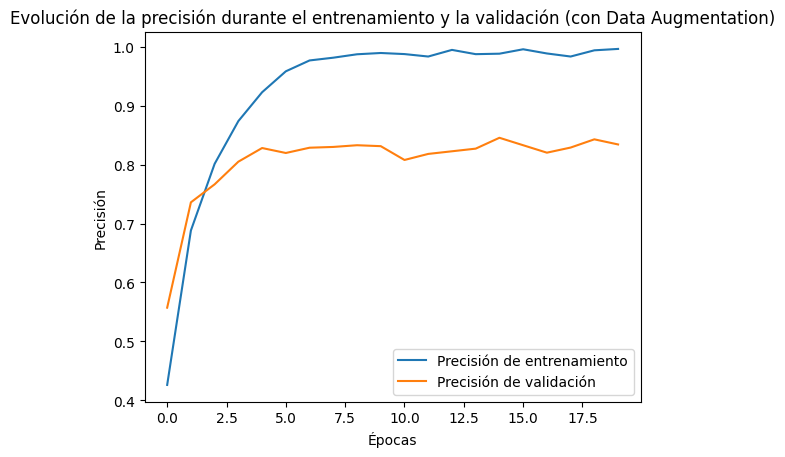

In [20]:
# Graficamos la evolución de las precisiones durante el entrenamiento y la validación
# Este bloque se encarga de graficar la precisión del entrenamiento y la validación a lo largo de las épocas.
plt.plot(history_DA.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history_DA.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Evolución de la precisión durante el entrenamiento y la validación (con Data Augmentation)')
plt.legend()
plt.show()

Vemos algo interesante: la precisión de entrenamiento sube 1 punto con respecto al dataset sin Data Augmentation, pero exponer al modelo a más imágenes diferentes no ha mejorado su generalización, de hecho, vemos en validación una estabilicizacion en torno a un 84% y una curva aplanada muy rápidamente en pérdida, todo ello sugiere que el modelo está aprendiendo bien los datos de entreanmiento pero que seguramente hay cierto sobreajuste.
De hecho, si revisamos el aumento contínuo de la pérdida de validación ya nos da un indicio claro de tal sobreajuste. La generalización no parece ser tan buena.
Qué podría hacerse? ya lo vimos en la práctica uno: Regularizar L2 o usar Early Stopping (o ambas) puede evitar ese sobreajuste. También podríamos intentar diferentes aproximaciones de Data Augmentation o modificar la tasa de aprendizaje, el tamaño del batch o el número de epocas.

28/28 - 0s - loss: 0.2239 - accuracy: 0.9730 - 136ms/epoch - 5ms/step
Precisión en el conjunto de test: 0.9730
28/28 [==============================] - 0s 4ms/step
                          precision    recall  f1-score   support

  abraham_grampa_simpson       1.00      0.96      0.98        48
  apu_nahasapeemapetilon       0.96      0.96      0.96        50
            bart_simpson       0.88      0.98      0.92        50
charles_montgomery_burns       0.98      0.94      0.96        48
            chief_wiggum       1.00      1.00      1.00        50
          comic_book_guy       1.00      0.98      0.99        49
          edna_krabappel       1.00      0.98      0.99        50
           homer_simpson       0.94      0.98      0.96        50
           kent_brockman       1.00      0.94      0.97        50
        krusty_the_clown       0.96      0.98      0.97        50
            lisa_simpson       0.94      0.96      0.95        50
           marge_simpson       1.00      0.

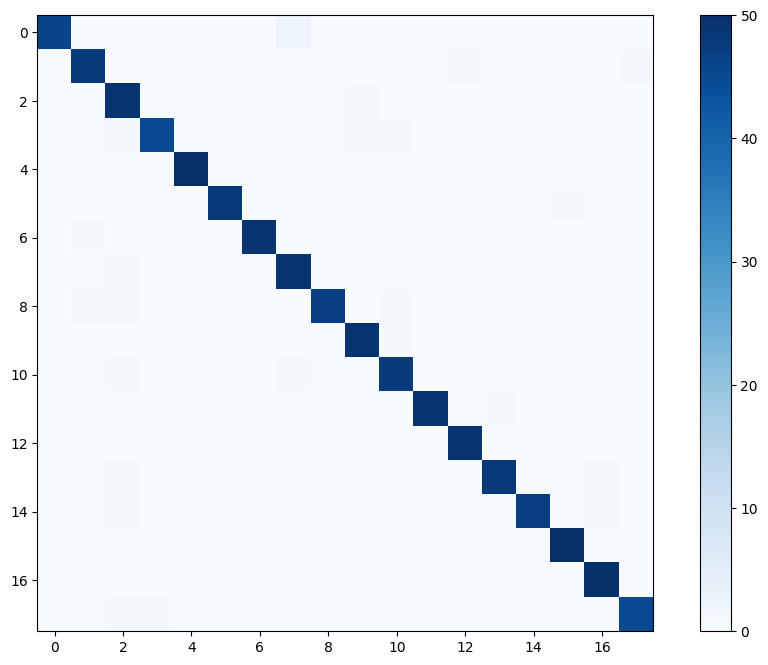

In [21]:
# Evaluación en el dataset de test
test_loss, test_acc = model_DA.evaluate(X_t, y_t, verbose=2)
print(f"Precisión en el conjunto de test: {test_acc:.4f}")

# Matriz de confusión y clasificación
from sklearn.metrics import classification_report, confusion_matrix

#Graficamos la matriz de confusión
y_pred = model_DA.predict(X_t)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_t, y_pred_classes, target_names=MAP_CHARACTERS.values()))
conf_matrix = confusion_matrix(y_t, y_pred_classes)
plt.figure(figsize=(12, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
plt.colorbar()
plt.show()

# **Descripción de Data Augmentation**
Data augmentation es una técnica utilizada para aumentar el tamaño y la diversidad del dataset mediante la aplicación de transformaciones aleatorias a las imágenes originales. Esto ayuda a que el modelo sea más robusto y generalice mejor a datos no vistos. Algunas de las transformaciones comunes incluyen:

Rotaciones aleatorias

Traslaciones horizontales y verticales

Flips horizontales

Zooms

Shear (cizallamiento)

Como vemos, con respecto a la parte inicial del ejercicio en el que usamos el set de datos tal cual, sin modificar, los cambios en el set de testeo son muy parecidos, sin embargo no hemos mejorado la precisión de validación , de hecho ha empeorado, aunque la precisión de testeo aumenta aquí casi 1%.
Estas técnicas, con un coste computacional limitado y que suponen una mejora en los resultados siempre van a ser interesantes de implementar, pero hay que tener mucho cuidado con los sobreajustes, tal y como hemos analizado anteriormente.

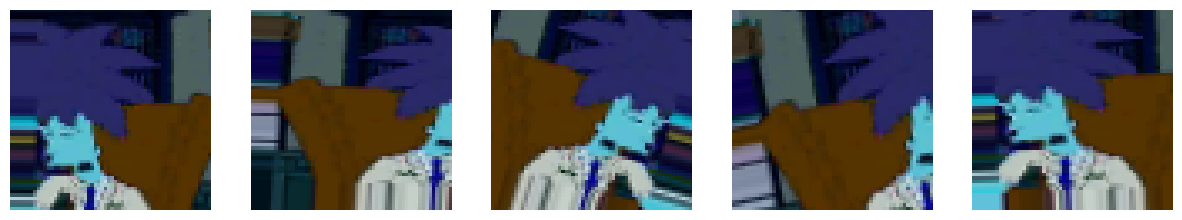

In [23]:
# Visualización de algunas imágenes aumentadas
import matplotlib.pyplot as plt

# Selecciona una imagen del dataset
img = X[1]

# Prepara un iterador para generar imágenes aumentadas
aug_iter = datagen.flow(np.expand_dims(img, axis=0))

# algunas imágenes augmentadas
fig, axes = plt.subplots(1, 5, figsize=(15, 15))
for i in range(5):
    aug_img = next(aug_iter)[0]
    axes[i].imshow(aug_img)
    axes[i].axis('off')
plt.show()


In [24]:
len(MAP_CHARACTERS)


18

In [25]:
#vamos a comparar con un modelo Fully Connected sencillito

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

# Definir el modelo FCN
fcn_model = Sequential()
fcn_model.add(Flatten(input_shape=(60, 60, 3)))
fcn_model.add(Dense(512, activation='relu'))
fcn_model.add(Dense(512, activation='relu'))
fcn_model.add(Dense(len(MAP_CHARACTERS), activation='softmax'))

# Compilar el modelo
fcn_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
fcn_history = fcn_model.fit(X, y, validation_split=0.2, epochs=20, batch_size=64)


Epoch 1/20
238/238 [==============================] - 3s 8ms/step - loss: 2.6299 - accuracy: 0.2506 - val_loss: 2.2430 - val_accuracy: 0.3185
Epoch 2/20
238/238 [==============================] - 2s 7ms/step - loss: 2.0810 - accuracy: 0.3707 - val_loss: 2.0550 - val_accuracy: 0.3754
Epoch 3/20
238/238 [==============================] - 2s 7ms/step - loss: 1.9301 - accuracy: 0.4145 - val_loss: 2.0018 - val_accuracy: 0.4017
Epoch 4/20
238/238 [==============================] - 1s 5ms/step - loss: 1.8031 - accuracy: 0.4524 - val_loss: 1.9093 - val_accuracy: 0.4167
Epoch 5/20
238/238 [==============================] - 1s 6ms/step - loss: 1.6596 - accuracy: 0.4977 - val_loss: 1.8635 - val_accuracy: 0.4314
Epoch 6/20
238/238 [==============================] - 1s 6ms/step - loss: 1.5873 - accuracy: 0.5173 - val_loss: 1.7958 - val_accuracy: 0.4567
Epoch 7/20
238/238 [==============================] - 1s 5ms/step - loss: 1.5249 - accuracy: 0.5318 - val_loss: 1.7395 - val_accuracy: 0.4864
Epoch 

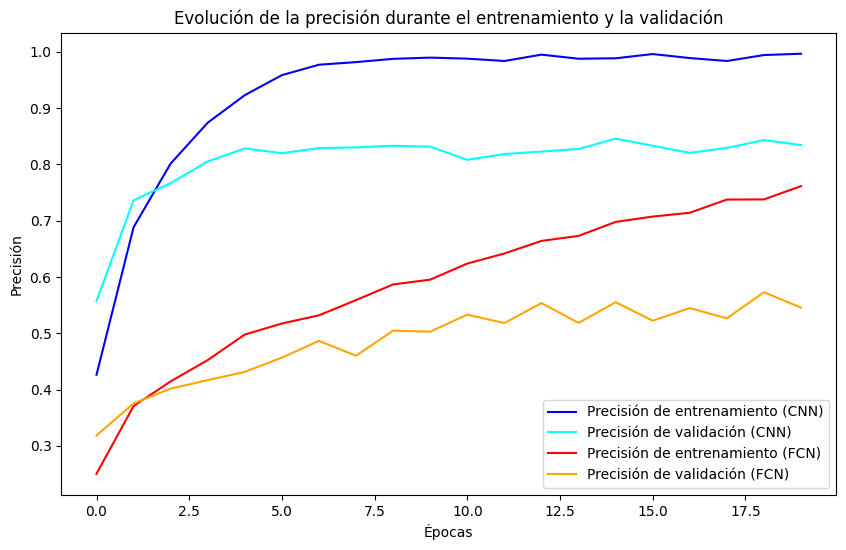

In [27]:

# Graficasmos la evolución de la precisión de entrenamiento y validación para ambos modelos
# vemos claramente que el modelo FCN tarda mucho más (en 20 epochs ni se acerca) en llegar a precisiones
# que la red convolucional tiene muy pronto (la asíntota CNN es mucho más temprana)

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Precisión del modelo CNN con Data Augmentation
plt.plot(history_DA.history['accuracy'], label='Precisión de entrenamiento (CNN)', color='blue')
plt.plot(history_DA.history['val_accuracy'], label='Precisión de validación (CNN)', color='cyan')

# Precisión del modelo Fully Connected
plt.plot(fcn_history.history['accuracy'], label='Precisión de entrenamiento (FCN)', color='red')
plt.plot(fcn_history.history['val_accuracy'], label='Precisión de validación (FCN)', color='orange')

# Añadir etiquetas y título
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Evolución de la precisión durante el entrenamiento y la validación')
plt.legend()

# Mostrar el gráfico
plt.show()

In [28]:
# Evaluación del modelo FCN
fcn_test_loss, fcn_test_acc = fcn_model.evaluate(X_t, y_t)
print('Precisión en test para el modelo Fully Connected:', fcn_test_acc)

# Evaluación del modelo CNN
cnn_test_loss, cnn_test_acc = model.evaluate(X_t, y_t)
print('Precisión en test para el modelo Convolucional:', cnn_test_acc)

# Evaluación del modelo CNN con DA
cnnDA_test_loss, cnnDA_test_acc = model_DA.evaluate(X_t, y_t)
print('Precisión en test para el modelo Convolucional con Data Augmentation:', cnnDA_test_acc)


28/28 [==============================] - 0s 3ms/step - loss: 1.0744 - accuracy: 0.6854
Precisión en test para el modelo Fully Connected: 0.6853932738304138
28/28 [==============================] - 0s 4ms/step - loss: 0.1548 - accuracy: 0.9719
Precisión en test para el modelo Convolucional: 0.9719101190567017
28/28 [==============================] - 0s 3ms/step - loss: 0.2239 - accuracy: 0.9730
Precisión en test para el modelo Convolucional con Data Augmentation: 0.9730337262153625


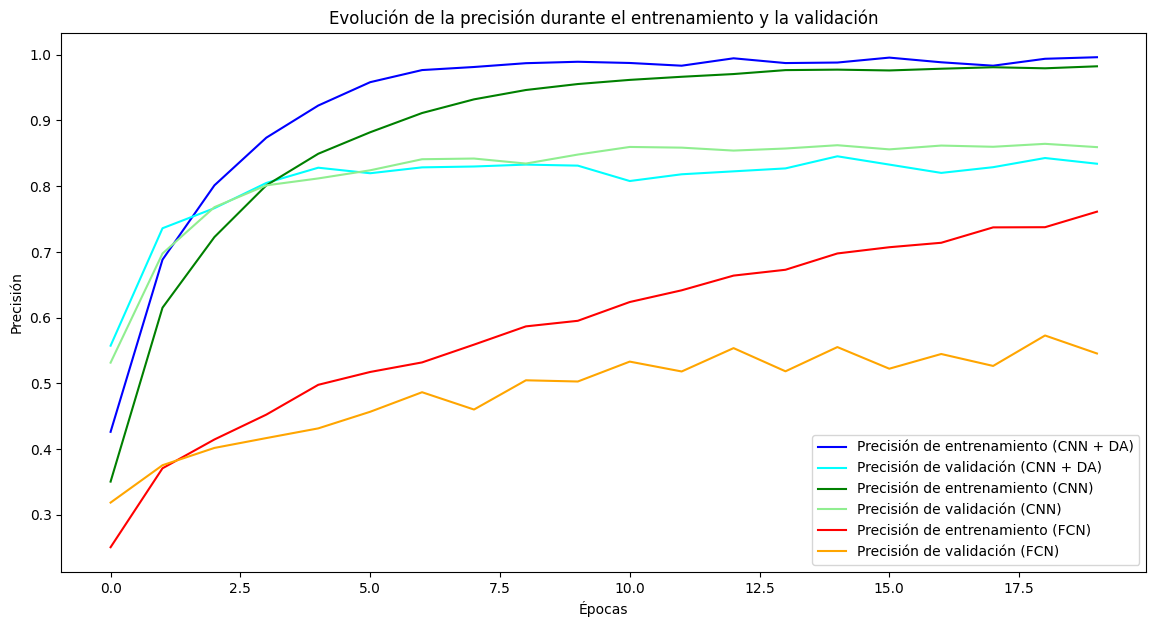

In [29]:
# Graficar la evolución de la precisión de entrenamiento y validación para los tres modelos
plt.figure(figsize=(14, 7))

# Precisión del modelo CNN con Data Augmentation
plt.plot(history_DA.history['accuracy'], label='Precisión de entrenamiento (CNN + DA)', color='blue')
plt.plot(history_DA.history['val_accuracy'], label='Precisión de validación (CNN + DA)', color='cyan')

# Precisión del modelo CNN
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento (CNN)', color='green')
plt.plot(history.history['val_accuracy'], label='Precisión de validación (CNN)', color='lightgreen')

# Precisión del modelo Fully Connected
plt.plot(fcn_history.history['accuracy'], label='Precisión de entrenamiento (FCN)', color='red')
plt.plot(fcn_history.history['val_accuracy'], label='Precisión de validación (FCN)', color='orange')

# Añadir etiquetas y título
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Evolución de la precisión durante el entrenamiento y la validación')
plt.legend()

# Mostrar el gráfico
plt.show()

In [32]:
#Pruebas con BatchNormalization, a ver qué pasa
def BNorm_model(input_shape, num_classes):
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        #las únicas diferencias, en realidad, son las de introducir
        # 3 capas de batchNormalizacion para ver si el modelo mejora
        # lo que hace es normalizar la activación de la capa anterior y a veces pueden acelerar el entrenamiento y mejorar la estabilidad
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),

        #capa de BatchNormalizacion
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),

        #capa de BatchNormalization
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Definimos hiperparámetros y compilamos el modelo
input_shape = (IMG_SIZE, IMG_SIZE, 3)
num_classes = len(MAP_CHARACTERS)
model = BNorm_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenamos el modelo
history_BN = model.fit(X, y, epochs=20, validation_split=0.2, batch_size=64)





Epoch 1/20
238/238 [==============================] - 7s 19ms/step - loss: 2.0352 - accuracy: 0.4320 - val_loss: 3.8649 - val_accuracy: 0.1685
Epoch 2/20
238/238 [==============================] - 3s 12ms/step - loss: 1.2099 - accuracy: 0.6352 - val_loss: 1.5084 - val_accuracy: 0.5357
Epoch 3/20
238/238 [==============================] - 3s 14ms/step - loss: 0.8428 - accuracy: 0.7419 - val_loss: 0.9320 - val_accuracy: 0.7265
Epoch 4/20
238/238 [==============================] - 3s 14ms/step - loss: 0.6145 - accuracy: 0.8075 - val_loss: 0.7154 - val_accuracy: 0.7857
Epoch 5/20
238/238 [==============================] - 4s 18ms/step - loss: 0.4550 - accuracy: 0.8608 - val_loss: 1.0285 - val_accuracy: 0.7239
Epoch 6/20
238/238 [==============================] - 3s 12ms/step - loss: 0.3207 - accuracy: 0.8966 - val_loss: 0.6566 - val_accuracy: 0.8186
Epoch 7/20
238/238 [==============================] - 3s 12ms/step - loss: 0.2533 - accuracy: 0.9197 - val_loss: 1.0498 - val_accuracy: 0.7518

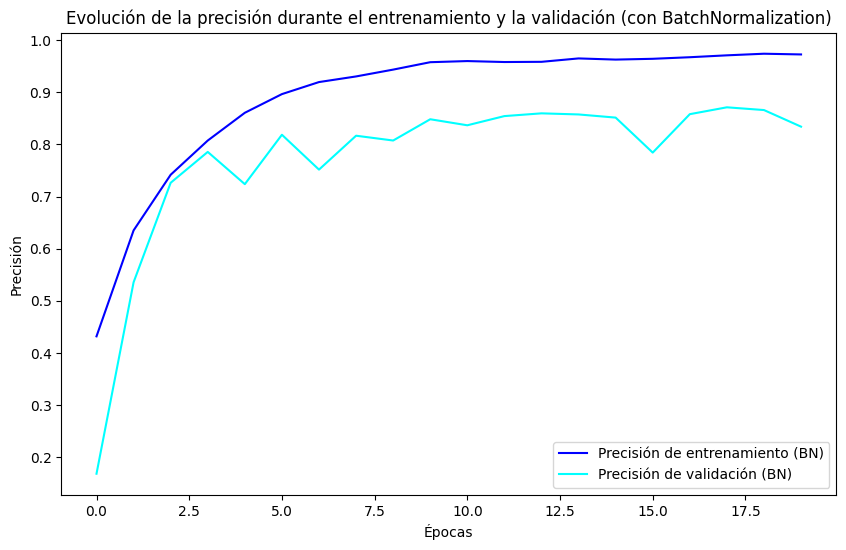

In [33]:
# Graficar la evolución de la precisión de entrenamiento y validación para el modelo con BatchNormalization

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Precisión del modelo con BatchNormalization
plt.plot(history_BN.history['accuracy'], label='Precisión de entrenamiento (BN)', color='blue')
plt.plot(history_BN.history['val_accuracy'], label='Precisión de validación (BN)', color='cyan')

# Añadir etiquetas y título
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Evolución de la precisión durante el entrenamiento y la validación (con BatchNormalization)')
plt.legend()

# Mostrar el gráfico
plt.show()

La gráfica muestra la evolución de la precisión de entrenamiento y validación del modelo convolucional con BatchNormalization.  que podemos analizar:

La precisión de entrenamiento continúa mejorando de manera constante y alcanza un valor cercano al 0.95 alrededor de la época 10. Después se estabiliza y se mantiene alta.

La precisión de validación muestra cierta variabilidad y no mejora significativamente, manteniéndose alrededor de 0.85, lo que ojo no está mal.
La variabilidad en la precisión de validación puede ser un indicio de que el modelo está empezando a sobreajustarse.
Quizá volvemos a tener cierto sobreajuste y falta de buena generalización.

BatchNormalization parece haber tenido un impacto positivo en la estabilización y aceleración del entrenamiento inicial. La precisión de entrenamiento mejora rápidamente y se estabiliza en valores altos.
Sin embargo, la estabilización en la precisión de validación sugiere que podríamos necesitar más técnicas de regularización para mejorar la generalización del modelo, como el uso de más datos de entrenamiento, aumento de datos (Data Augmentation), o técnicas de regularización adicionales.


28/28 - 0s - loss: 0.2607 - accuracy: 0.9427 - 112ms/epoch - 4ms/step
Precisión en el conjunto de test: 0.9427
28/28 [==============================] - 0s 3ms/step
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.84      0.96      0.89        48
  apu_nahasapeemapetilon       0.88      0.98      0.92        50
            bart_simpson       0.94      0.90      0.92        50
charles_montgomery_burns       0.95      0.81      0.88        48
            chief_wiggum       0.96      1.00      0.98        50
          comic_book_guy       0.96      0.92      0.94        49
          edna_krabappel       0.94      0.98      0.96        50
           homer_simpson       0.81      0.94      0.87        50
           kent_brockman       1.00      0.96      0.98        50
        krusty_the_clown       0.98      1.00      0.99        50
            lisa_simpson       0.98      0.88      0.93        50
           marge_simpson       1.00      0.

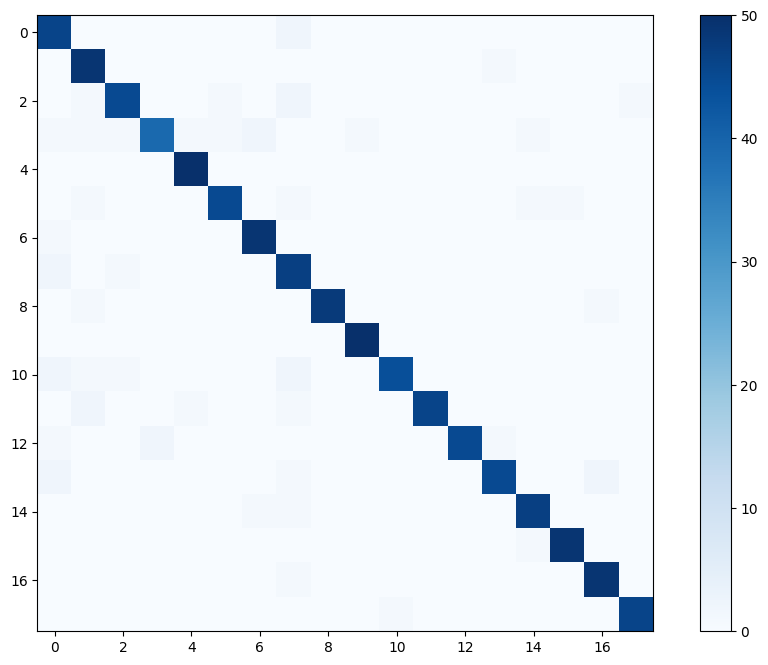

In [34]:
# Evaluación en el dataset de test
test_loss, test_acc = model.evaluate(X_t, y_t, verbose=2)
print(f"Precisión en el conjunto de test: {test_acc:.4f}")

# Matriz de confusión y clasificación
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_t)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_t, y_pred_classes, target_names=MAP_CHARACTERS.values()))
conf_matrix = confusion_matrix(y_t, y_pred_classes)
plt.figure(figsize=(12, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
plt.colorbar()
plt.show()

# Análisis:

Lo cierto es que las ideas más interesantes que podemos extraer de este ejercicio son la importancia en la elección de la arquitectura y de la hiperparametrización de esa arquitectura para afinar la precisión del modelo en base a lo buscado.

Durante el desarrollo de la práctica tuve la oportunidad de leer estudios similares que apostaban por transfer learning (vía la exploración de ResNet y otras) y replicado de AlexNet con extraordinarios resultados.

Me encantaría tener tiempo y recursos para analizar estas ideas (y de hecho no lo descarto). Las referencias a estos estudios son:
 https://andrewlauactuary.com/2021/09/02/cnn-simpsons-image-classifier-part-1-training-in-pytorch/ y
https://cs230.stanford.edu/projects_winter_2019/reports/15811843.pdf

que me han parecido super divertidos e interesantes de leer. Una lástima no disponer de tiempo para ejecutar ideas parecidas.

# Más historias? :

Regularización Adicional:

Considerar el uso de técnicas de regularización adicionales como L2 regularization, o Early Stopping para evitar el sobreajuste.

Data Augmentation:
Implementar técnicas de Data Augmentation pero al mismo tiempo que BatchNormalization, para generar más datos de entrenamiento y ayudar al modelo a generalizar mejor.

Ajuste de Hiperparámetros:
Una cosa que siempre consiero y que me gusta mucho hacer es experimentar con diferentes configuraciones de hiperparámetros, como la tasa de aprendizaje, el tamaño del lote y el número de épocas, para encontrar un mejor equilibrio entre el ajuste y la generalización. Las técncias de Grid con validación cruzada (o asemejadas según el modelado) es algo que me parece interesante porque en ocasiones vemos la relación mejora/coste computacional , dando muchas razones para la toma de decisiones informada.


# Evaluación Continua:

Continuar evaluando el modelo con diferentes conjuntos de datos de validación para asegurar que el modelo está generalizando bien y no está sobreajustado a un conjunto específico de datos.

En resumen, aunque BatchNormalization ha mejorado la estabilidad y la precisión de entrenamiento del modelo, DataAugmentation nos ha permitido tener más datos con los que entrenar a nuestro modelo y técnicas como dropout pueden ayudar a generalizar mejor, es importante seguir trabajando en la mejora de la precisión de validación y la generalización del modelo para obtener un rendimiento óptimo en datos no vistos.

# **IMPORTANTE: Revisar ANEXO I con la hoja de revisión de participación grupal en la actividad. **